# Multiclass Support Vector Machine exercise

*Compelete and hand in this completed worksheet(including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignment page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:

- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10
#default set,use this can make plt show in this page rather than another page
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%reload_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
datapath = 'cs231n/datasets/cifar10'
X_train, y_train, X_test, y_test = load_CIFAR10(datapath)
print('the shape of training data',X_train.shape)
print('the shape of training data label',y_train.shape)
print('the shape of testing data',X_test.shape)
print('the shape of testing data label',y_test.shape)

the shape of training data (50000, 32, 32, 3)
the shape of training data label (50000,)
the shape of testing data (10000, 32, 32, 3)
the shape of testing data label (10000,)


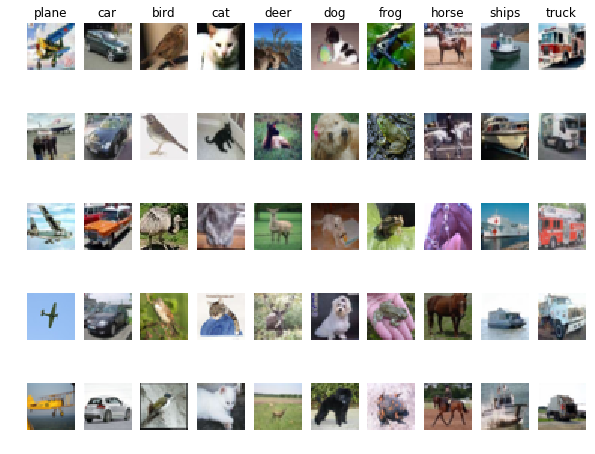

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ships', 'truck']
num_class = len(classes)
sample_per_class = 5
for i,name in enumerate(classes):
    idxs = np.flatnonzero(y_train == i)
    idxs = np.random.choice(idxs,sample_per_class,replace=False)
    for j,idx in enumerate(idxs):
        plt_idx = j * num_class + i + 1
        plt.subplot(sample_per_class,num_class,plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if j == 0:
            plt.title(name)
plt.show()

In [4]:
num_train = 49000
num_validation = 1000
num_test =1000
num_dev = 500
#the last one is for development
mask = range(num_train,num_train + num_validation)#the last num_validation points
X_val = X_train[mask]
y_val = y_train[mask]
mask = range(num_train)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]
mask = np.random.choice(num_train,num_dev,replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]
print('the shape of training data',X_train.shape)
print('the shape of training data label',y_train.shape)
print('the shape of testing data',X_test.shape)
print('the shape of testing data label',y_test.shape)
print('the shape of validation data',X_val.shape)
print('the shape of validation data label',y_val.shape)
print('the shape of development data',X_dev.shape)
print('the shape of development data label',y_dev.shape)

the shape of training data (49000, 32, 32, 3)
the shape of training data label (49000,)
the shape of testing data (1000, 32, 32, 3)
the shape of testing data label (1000,)
the shape of validation data (1000, 32, 32, 3)
the shape of validation data label (1000,)
the shape of development data (500, 32, 32, 3)
the shape of development data label (500,)


In [5]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
print('the shape of training data',X_train.shape)
print('the shape of training data label',y_train.shape)
print('the shape of testing data',X_test.shape)
print('the shape of testing data label',y_test.shape)
print('the shape of validation data',X_val.shape)
print('the shape of validation data label',y_val.shape)
print('the shape of development data',X_dev.shape)
print('the shape of development data label',y_dev.shape)

the shape of training data (49000, 3072)
the shape of training data label (49000,)
the shape of testing data (1000, 3072)
the shape of testing data label (1000,)
the shape of validation data (1000, 3072)
the shape of validation data label (1000,)
the shape of development data (500, 3072)
the shape of development data label (500,)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


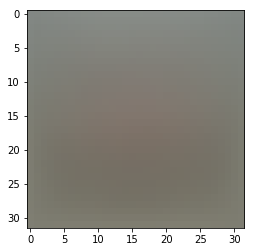

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train,axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape(32,32,3).astype('uint8'))
plt.show()

In [7]:
# second: subtract the mean image from train and test data
#normazation
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train,np.ones((X_train.shape[0],1))])
X_test = np.hstack([X_test,np.ones((X_test.shape[0],1))])
X_val = np.hstack([X_val,np.ones((X_val.shape[0],1))])
X_dev = np.hstack([X_dev,np.ones((X_dev.shape[0],1))])
print(X_train.shape,X_test.shape,X_val.shape,X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

W = np.random.randn(3073,10) * 0.0001
loss,grad = svm_loss_naive(W,X_dev,y_dev,0.00001)
print('loss: %f'%(loss,))

loss: 8.948357


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
#关闭正则化，防止梯度大部分来源于正则项
loss, grad = svm_loss_naive(W,X_dev,y_dev,0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse

f = lambda w: svm_loss_naive(w,X_dev,y_dev,0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W,X_dev,y_dev,1e2)
f = lambda w: svm_loss_naive(w,X_dev,y_dev,1e2)[0]
grad_numerical = grad_check_sparse(f,W,grad)

numerical: 1.845544 analytic: 1.845544, relative error: 9.072140e-11
numerical: 15.527935 analytic: 15.527935, relative error: 1.811862e-11
numerical: -24.381306 analytic: -24.381306, relative error: 8.633302e-12
numerical: 17.831372 analytic: 17.831372, relative error: 3.440866e-12
numerical: -5.349619 analytic: -5.349619, relative error: 3.072287e-11
numerical: -42.186552 analytic: -42.186552, relative error: 3.767245e-12
numerical: -4.485409 analytic: -4.485409, relative error: 2.626669e-11
numerical: 11.856536 analytic: 11.856536, relative error: 1.136519e-11
numerical: 15.182954 analytic: 15.182954, relative error: 1.844302e-11
numerical: 10.896522 analytic: 10.896522, relative error: 1.653371e-11
numerical: -30.513464 analytic: -30.513464, relative error: 1.187404e-11
numerical: 2.588091 analytic: 2.588091, relative error: 5.489387e-11
numerical: -25.080439 analytic: -25.080439, relative error: 8.603848e-12
numerical: 7.817275 analytic: 7.817275, relative error: 2.293009e-11
nume

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *If a dimension in the gradcheck not match exactly, it may caused by the oversized step **h** or **regularation**, the former may cause the inoperative X operative by plus h, the later may take up the basis of gradient if it's oversize*

In [11]:
import time
tic = time.time()
loss_naive,_ = svm_loss_naive(W,X_dev,y_dev,0.0001)
toc = time.time()
print('Loss naive %f computed in %fs'%(loss_naive,toc-tic))
from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized,_ = svm_loss_vectorized(W,X_dev,y_dev,0.0001)
toc = time.time()
print('Loss vectorized %f computed in %fs'%(loss_vectorized,toc-tic))
#vectorized computed is faster about 20 times than naive
print('difference:%f'%(loss_vectorized - loss_naive))

Loss naive 8.948357 computed in 0.179117s
Loss vectorized 8.948357 computed in 0.015010s
difference:-0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('difference: %f' % difference)

Naive loss and gradient: computed in 0.169112s
Vectorized loss and gradient: computed in 0.015012s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
from cs231n.classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
#return a list include all loss
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,num_iters=1500, verbose=True)
toc = time.time()
print('that tooks %f'%(toc - tic))

Iteration 0/1500: loss 784.278697
Iteration 100/1500: loss 285.817291
Iteration 200/1500: loss 107.113282
Iteration 300/1500: loss 42.100177
Iteration 400/1500: loss 18.624037
Iteration 500/1500: loss 10.508594
Iteration 600/1500: loss 6.764758
Iteration 700/1500: loss 5.805013
Iteration 800/1500: loss 5.863068
Iteration 900/1500: loss 5.478263
Iteration 1000/1500: loss 5.259865
Iteration 1100/1500: loss 5.720339
Iteration 1200/1500: loss 5.299537
Iteration 1300/1500: loss 5.168793
Iteration 1400/1500: loss 4.922361
that tooks 13.755105


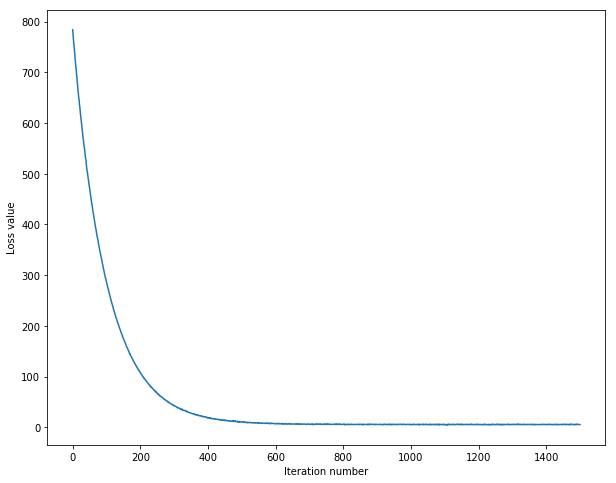

In [14]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
y_train_pred = svm.predict(X_train)
print('training accuracy:%f'%(np.mean(y_train_pred == y_train)))
y_val_pred = svm.predict(X_val)
print('validatino accuracy:%f'%(np.mean(y_val_pred == y_val)))

training accuracy:0.369694
validatino accuracy:0.389000


In [16]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e5]
best_val = -1
best_svm = None
results = {}
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=rs, 
                  num_iters=1500, verbose=False)
        
        y_train_pred = svm.predict(X_train)
        y_train_accuracy = np.mean(y_train_pred == y_train)
        y_val_pred = svm.predict(X_val)
        y_val_accuracy = np.mean(y_val_pred == y_val)
        
        results[(lr,rs)] = (y_train_accuracy,y_val_accuracy)
        if y_val_accuracy > best_val:
            best_val = y_val_accuracy
            best_svm = svm
for lr, rs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rs)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f'%(lr, rs, train_accuracy, val_accuracy))
print('best validation accuracy achieved during cross-validation: %f' % best_val)

C:\Users\luoxiang\AnacondaProjects\assignment1\cs231n\classifiers\linear_svm.py:66: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W*W)     #plus the regularizatin using L2 distace of w,which is also name euclidean metric
C:\Users\luoxiang\AnacondaProjects\assignment1\cs231n\classifiers\linear_svm.py:66: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W*W)     #plus the regularizatin using L2 distace of w,which is also name euclidean metric
C:\Users\luoxiang\AnacondaProjects\assignment1\cs231n\classifiers\linear_svm.py:70: RuntimeWarning: overflow encountered in multiply
  dw += np.dot(X.T,margin)/num_train + reg * W
C:\Users\luoxiang\AnacondaProjects\assignment1\cs231n\classifiers\linear_svm.py:62: RuntimeWarning: invalid value encountered in maximum
  margin = np.maximum(0, margin)
C:\Users\luoxiang\AnacondaProjects\assignment1\cs231n\classifiers\linear_svm.py:67: RuntimeWarning: invalid value encountered in greater
 

lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.375122 val accuracy: 0.373000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.353776 val accuracy: 0.362000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.055551 val accuracy: 0.052000
lr 5.000000e-05 reg 1.000000e+05 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.373000


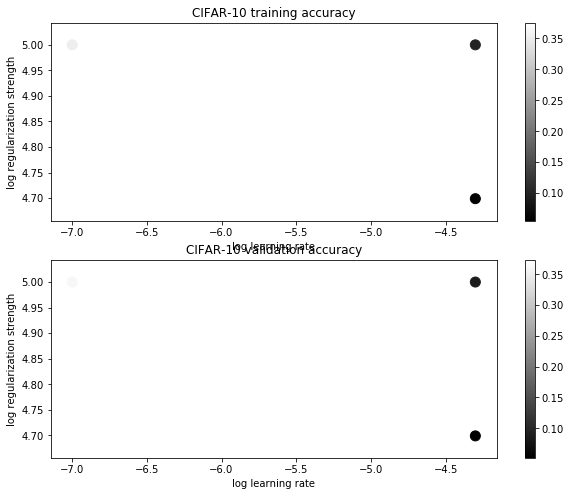

In [17]:
import math
#(learning_rates,regularzation_strengths):(y_train_accuracy,y_val_accuracy)
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

#plot train points accuracy
mark_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2,1,1)
plt.scatter(x_scatter, y_scatter, mark_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
#plot validation points accuracy

colors = [results[x][1] for x in results]
plt.subplot(2,1,2)
plt.scatter(x_scatter,y_scatter,mark_size,c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test_pred == y_test)
print('linear SVM on raw pixels final set accuracy:%f'%(test_accuracy))

linear SVM on raw pixels final set accuracy:0.378000


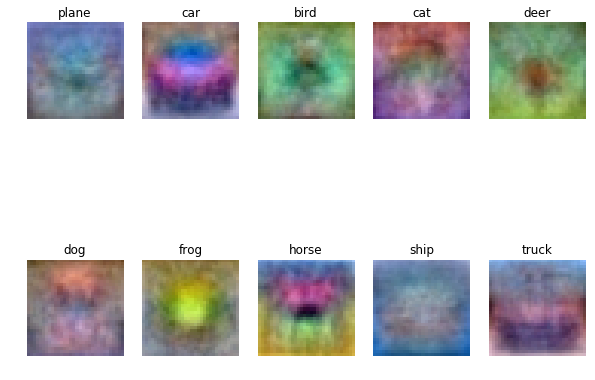

In [19]:
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])